# Spotify Extended History

The following notebook is an experimental exploration of Spotify's **Extended History**.
The data is requested from Spotify and contains every individual play (by my account) from **October 2015** until **March 2023**.

In [1]:
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import ipywidgets
from IPython.display import Markdown, display
from dotenv import load_dotenv

In [2]:
df = pd.concat(map(pd.read_json, ["data/endsong_0.json", "data/endsong_1.json", "data/endsong_2.json", "data/endsong_3.json", "data/endsong_4.json", "data/endsong_5.json"]))
df.iloc[[0,-1]]

,ts,username,platform,ms_played,conn_country,ip_addr_decrypted,user_agent_decrypted,master_metadata_track_name,master_metadata_album_artist_name,master_metadata_album_album_name,...,episode_name,episode_show_name,spotify_episode_uri,reason_start,reason_end,shuffle,skipped,offline,offline_timestamp,incognito_mode
0,2015-10-04T17:25:52Z,thatollom,"Android OS 4.4.2 API 19 (THL, thl 5000)",121393,DE,95.91.224.1,unknown,Play Hard (feat. Ne-Yo & Akon),David Guetta,Nothing but the Beat,...,NaN,NaN,NaN,clickrow,endplay,False,1.0,False,0,False
6038,2023-05-14T22:12:55Z,thatollom,ios,154381,DE,37.4.229.9,unknown,Dawn of the Dragonstar,Twilight Force,Dawn of the Dragonstar,...,None,None,None,trackdone,endplay,False,1.0,False,1684074699,False


Remove known artists, that cannot be used in a music listening analysis. 

In [3]:
df.drop(columns=["username", "ip_addr_decrypted", "user_agent_decrypted", "offline_timestamp", "incognito_mode"], inplace=True)
df = df.drop(df[df["master_metadata_album_artist_name"] == "Die drei !!!"].index)
df = df.drop(df[df["master_metadata_album_artist_name"] == "Rick Riordan"].index)

In [4]:
df["ts"] = pd.to_datetime(df["ts"])
original_length = len(df)

In [5]:
unique_tracks = df["master_metadata_track_name"].unique()
print(len(unique_tracks), "unique tracks have been played")

17618 unique tracks have been played


In [6]:
df.groupby(df["master_metadata_track_name"])["spotify_track_uri"].first().to_frame().to_csv("tracks_with_uri.csv")

---
**Data:**
- `df` All columns; Only songs that have been played at least 10 times.
- `df_orig` All columns.
- `unique_tracks` Every track played.

**Edit:**
Upon further inspection, the 2015 data appear to be characterisec by irregular usage and a general lack of significance and thus will be excluded from the dataset.

In [7]:
df_top_tracks = df["master_metadata_track_name"].value_counts().to_frame()
df_top_tracks = df_top_tracks.reset_index().rename(columns={"master_metadata_track_name":"name","count":"plays"})
df_top_tracks.head()

,name,plays
0,T-Shirt Song,199
1,Nothing,187
2,Punk Rock Songs,178
3,"Young, Wild & Free (feat. Bruno Mars)",173
4,Young as the Morning Old as the Sea,169


In [8]:
top_names = df_top_tracks[df_top_tracks["plays"]>=10]["name"]
df_orig = df
df = df[df["master_metadata_track_name"].isin(top_names)].reset_index(drop=True)
# Edit:
df = df[df["ts"].dt.year != 2015]

print("original length:", original_length)
print(" reduced length:", len(df))
print("      reduction:", str(round(len(df)/original_length*100,2))+"%")

original length: 78415
 reduced length: 41439
      reduction: 52.85%


<div class="alert alert-block alert-success"> 
    It could be useful to further only include tracks,
    that have been played at lead 30% (or 50%) of their length. <br>
    Including skipped tracks carries the risk of further distorting the real hearing-bahavior.

</div>

In [9]:
num_skipped = len(df_orig[df_orig["skipped"] == 1])
print(round(num_skipped/len(df_orig)*100,2), "% of tracks have been skipped.") 

2.39 % of tracks have been skipped.


Though only a small percentage of tracks have been skipped, it is unlikeley, that the remaining tracks have been played to the end.


In [10]:
reason_end_count = df_orig["reason_end"].value_counts(normalize=True).to_frame().reset_index().rename({"count":"reason_end"}, axis=1)
reason_end_count

,reason_end,proportion
0,trackdone,0.547434
1,endplay,0.183345
2,fwdbtn,0.141134
3,logout,0.056635
4,unexpected-exit-while-paused,0.028732
5,unexpected-exit,0.012702
6,backbtn,0.010062
7,unknown,0.009564
8,playbtn,0.005394
9,remote,0.003928


<Axes: xlabel='proportion', ylabel='reason_end'>

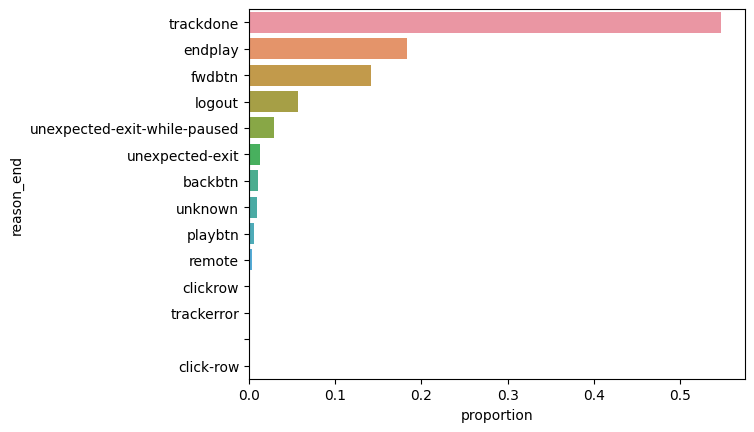

In [11]:
sns.barplot(data=reason_end_count, x="proportion", y="reason_end")

---
Songs played per year.

(only skipped excluded)

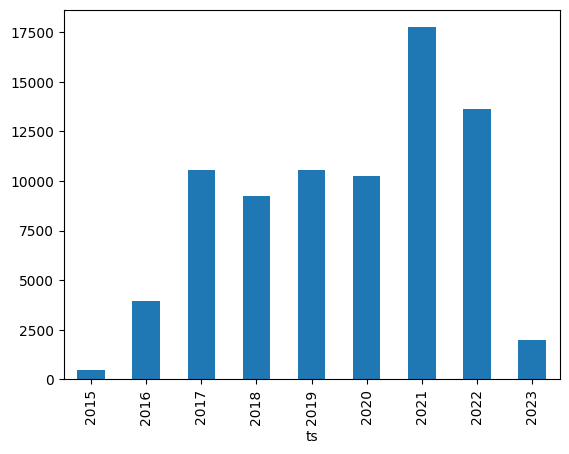

In [12]:
df_orig.groupby(df_orig["ts"].dt.year)["ts"].count().plot(kind="bar")
plt.show()

---
Songs per year per quarter.

<Axes: xlabel='ts'>

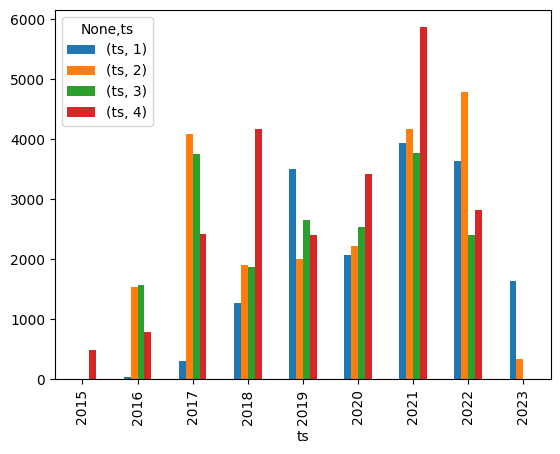

In [13]:
df_my = df_orig.groupby([df_orig["ts"].dt.year, df_orig["ts"].dt.quarter])["ts"].agg("count").to_frame()
df_my.index.sortlevel(0, sort_remaining=True)
df_my.unstack().plot(kind="bar", stacked=False)

---
Finding the longes heared tracks.

In [14]:
##### config ######
calculate = False
###################

if calculate:
    df_playcount = df["master_metadata_track_name"].value_counts().to_frame()
    df_from_to = pd.DataFrame(columns=["track_name", "plays", "first_played", "last_played", "days_between", "days_played"])

    for song, plays in tqdm.notebook.tqdm(df_playcount.iterrows(), total=df_playcount.shape[0]):
        first_ts = df[df["master_metadata_track_name"] == song].iloc[0]["ts"]
        last_ts = df[df["master_metadata_track_name"] == song].iloc[-1]["ts"]

        df_ts = df.set_index("ts")
        df_ts_filtered = df_ts[df_ts["master_metadata_track_name"] == song]
        days_played = len(df_ts_filtered.groupby(df_ts_filtered.index.date).count())

        row = {
            "track_name": song,
            "plays": plays.values[0],
            "first_played": first_ts,
            "last_played": last_ts,
            "days_between": (last_ts - first_ts).days,
            "days_played": days_played,
        }
        new_df = pd.DataFrame([row])
        df_from_to = pd.concat([df_from_to, new_df], ignore_index=True)

    df_from_to.to_csv("df_from_to.csv")
else:
    df_from_to = pd.read_csv("df_from_to.csv")

df_from_to

,Unnamed: 0,track_name,plays,first_played,last_played,days_between,days_played
0,0,T-Shirt Song,201,2018-01-14 21:02:25+00:00,2022-09-23 16:51:53+00:00,1712,92
1,1,Punk Rock Songs,195,2021-11-08 05:54:24+00:00,2023-04-24 09:46:14+00:00,532,128
2,2,Nothing,194,2021-10-13 12:28:43+00:00,2023-05-11 17:40:42+00:00,575,100
3,3,"Young, Wild & Free (feat. Bruno Mars)",182,2016-01-24 11:15:06+00:00,2022-02-17 15:23:58+00:00,2216,89
4,4,Young as the Morning Old as the Sea,179,2016-10-09 10:48:16+00:00,2021-11-23 14:41:52+00:00,1871,76
...,...,...,...,...,...,...,...
1325,1325,Die Young,9,2019-09-14 19:36:20+00:00,2023-01-30 13:03:05+00:00,1233,7
1326,1326,"104,481",8,2017-05-06 08:22:35+00:00,2021-05-20 06:01:29+00:00,1474,8
1327,1327,Kalle macht den Song,5,2016-11-14 18:18:16+00:00,2020-10-07 05:45:08+00:00,1422,5
1328,1328,Vergleiche a la Boss,4,2017-05-06 08:22:35+00:00,2020-10-07 05:27:00+00:00,1249,4


---
Top five songs per year with individual plays.

In [15]:
df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().groupby(level=0, group_keys=False).head(5)

ts    master_metadata_track_name                        
2016  Rasta Got Soul                                         74
      Young, Wild & Free (feat. Bruno Mars)                  66
      No Money                                               50
      I Took A Pill In Ibiza - Seeb Remix                    46
      Stimme                                                 45
2017  Young as the Morning Old as the Sea                   113
      Everyday (feat. Rod Stewart, Miguel & Mark Ronson)    101
      Catch & Release (Deepend remix)                        90
      Xenogenesis                                            87
      Semi-Automatic                                         73
2018  Fast Forward                                          107
      T-Shirt Song                                          104
      The Heart from Your Hate                               95
      Freeze Me                                              94
      Alles probiert                           

---
Histogram individual plays, per year.

In [16]:
plays_by_year = df.groupby(df["ts"].dt.year)["master_metadata_track_name"].value_counts().to_frame()
plays_by_year.index.rename(["year", "track_name"], inplace=True)
plays_by_year = plays_by_year.reset_index()
plays_by_year.rename({"count":"individual_plays"},axis=1, inplace=True)
plays_by_year.head(3)

,year,track_name,individual_plays
0,2016,Rasta Got Soul,74
1,2016,"Young, Wild & Free (feat. Bruno Mars)",66
2,2016,No Money,50


In [17]:
# pby = plays_by_year[plays_by_year["individual_plays"] < 50]
sea = sns.FacetGrid(plays_by_year[["year", "individual_plays"]], col="year", col_wrap=3)

plot = sea.map_dataframe(sns.histplot, "individual_plays", stat="percent", discrete=True)
year_counts = plays_by_year["individual_plays"].groupby(plays_by_year["year"]).count().reset_index(name="plays").set_index("year")
### Jupyter Setup ###
out1 = ipywidgets.widgets.Output()
with out1:
    display(year_counts)
out2 = ipywidgets.widgets.Output()
with out2:
    display(plot)
    plt.show()
two_columns = ipywidgets.widgets.HBox([out1, out2])
display(two_columns)

---
Portion of the top **5 (10, 20)** songs of the month in total plays.
> **TODO:** Amount of unique tracks that month

In [18]:
##### config #####
calculate = False
##################

if calculate:
    top_n = [5, 10, 20]
    dfs = []
    dates = df_orig["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
    for n in top_n:
        df_top_month = pd.DataFrame(columns=["plays"], index=dates)
        for date in tqdm.notebook.tqdm(df_top_month.index):
            entries = df_orig[df_orig["ts"].dt.strftime("%y - %m") == date]
            total_plays = len(entries)
            s_top_n = entries["master_metadata_track_name"].value_counts().head(n)
            top_n_plays = s_top_n.sum()
            top_n_tracks = s_top_n.index.tolist()
            top_n_portion = round(top_n_plays / total_plays * 100, 2)
            df_top_month.at[date] = top_n_portion
        dfs.append(df_top_month)

    df_top_all_n = pd.concat(dfs, axis=1)
    df_top_all_n.index = pd.to_datetime(df_top_all_n.index, format="%y - %m")
    df_top_all_n.columns = ["plays5","plays10", "plays20"]
    df_top_all_n.to_csv("df_top_all_n.csv")
else:
    df_top_all_n = pd.read_csv("df_top_all_n.csv")

<Axes: >

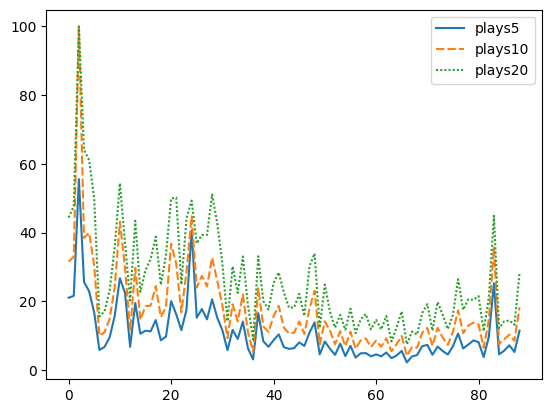

In [19]:
fig, ax = plt.subplots()
sns.lineplot(data=df_top_all_n[["plays5", "plays10", "plays20"]])

---
Graphing the five most played song with their respective **plays per month**.

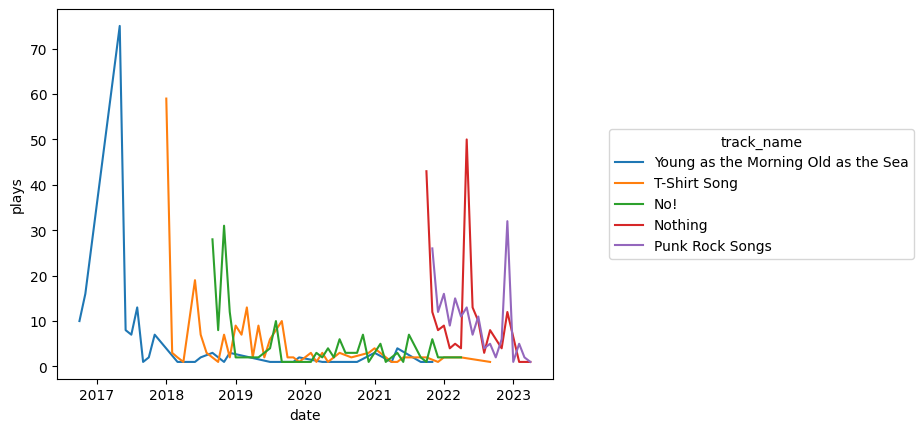

In [20]:
top10 = df["master_metadata_track_name"].value_counts().iloc[:5].index.values
data = df[df["master_metadata_track_name"].isin(top10)]
data = data.groupby([data["ts"].dt.year, data["ts"].dt.month], group_keys=False) \
    ["master_metadata_track_name"].value_counts().to_frame().rename_axis(["year", "month", "track_name"]).reset_index(2) \
    .rename({"count":"plays"}, axis=1).reset_index()
data["date"] = pd.to_datetime(data[["year", "month"]].assign(DAY=1))
data = data.drop(["year", "month"], axis=1)


ax = sns.lineplot(data=data, x="date", y="plays", hue="track_name")
sns.move_legend(ax, "center left", bbox_to_anchor=(1.1,0.5))

---
Hearing by Weekday.

<Axes: xlabel='weekday', ylabel='count'>

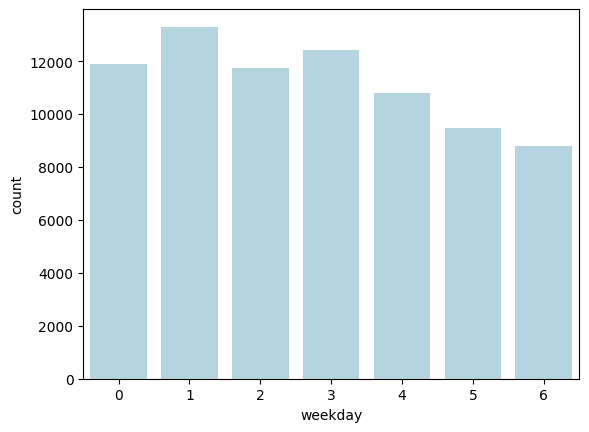

In [21]:
df_weekday_plays = df_orig.groupby(df_orig["ts"].dt.weekday)["ts"].count().to_frame()
df_weekday_plays.index.rename("weekday", inplace=True)
df_weekday_plays.reset_index(inplace=True)
df_weekday_plays.rename({"ts":"count"}, inplace=True, axis=1)

sns.barplot(data=df_weekday_plays, x="weekday", y="count", color="lightblue")

<Axes: xlabel='hour', ylabel='count'>

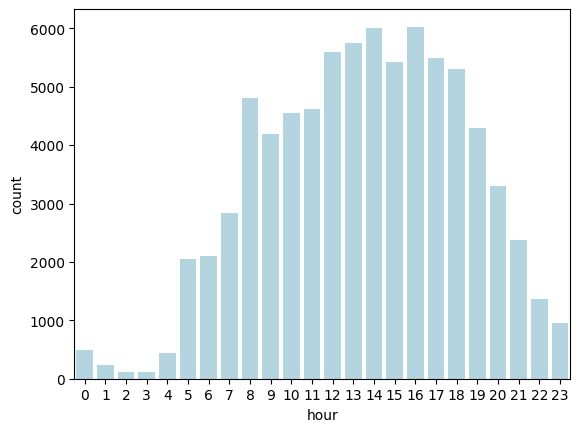

In [22]:
df_weekday_plays = df_orig.groupby(df_orig["ts"].dt.hour)["ts"].count().to_frame()
df_weekday_plays.index.rename("hour", inplace=True)
df_weekday_plays.reset_index(inplace=True)
df_weekday_plays.rename({"ts":"count"}, inplace=True, axis=1)

sns.barplot(data=df_weekday_plays, x="hour", y="count", color="lightblue")

/home/olevoss/.local/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


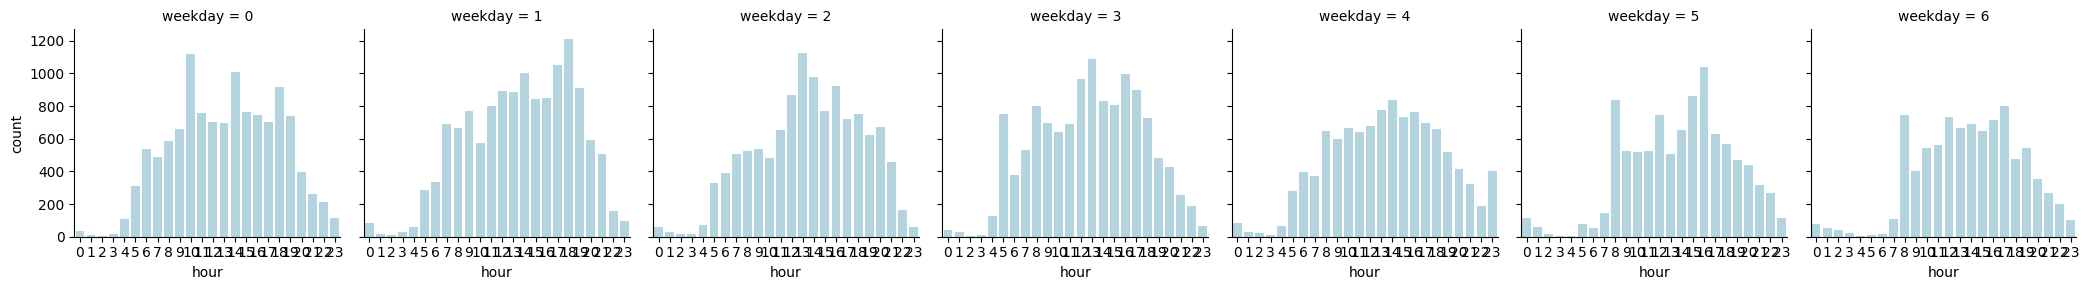

In [23]:
df_weekday_plays = df_orig.groupby([df_orig["ts"].dt.weekday, df_orig["ts"].dt.hour])["ts"].count().to_frame()
df_weekday_plays.columns = ["count"]
df_weekday_plays.index.rename(["weekday", "hour"], inplace=True)
df_weekday_plays = df_weekday_plays.reset_index()

sea = sns.FacetGrid(df_weekday_plays, col="weekday")
sea.map(sns.barplot, "hour", "count", color="lightblue")

---
# Interpretes

In [24]:
df_artist = df_orig[["ts", "master_metadata_track_name", "master_metadata_album_artist_name"]].rename(\
    columns={"master_metadata_track_name":"track_name","master_metadata_album_artist_name":"artist_name"})
df_artist.head()

,ts,track_name,artist_name
0,2015-10-04 17:25:52+00:00,Play Hard (feat. Ne-Yo & Akon),David Guetta
1,2015-10-04 17:26:12+00:00,A Brief Tutorial On Vip Production - Vip,Dubba Jonny
2,2015-10-04 17:26:24+00:00,No Holds Barred - Excision Remix,Foreign Beggars
3,2015-10-04 17:26:26+00:00,Clowns - Milo & Otis Trap VIP,KillaGraham
4,2015-10-04 17:27:00+00:00,Defend Earth - Original Mix,Sub Antix


In [25]:
n = 10
top_n = df_artist.groupby(df_artist["ts"].dt.year)["artist_name"].value_counts().groupby(level=0, group_keys=False).head(n).to_frame().reset_index()
top_n["songs"] = np.zeros(len(top_n)).astype(int)
top_n["var"] = np.zeros(len(top_n))
top_n["std"] = np.zeros(len(top_n))
for i, row in top_n.iterrows():
    data = df_artist.loc[(df_artist["artist_name"] == row["artist_name"]) & (df_artist["ts"].dt.year == row["ts"])]
    individual_tracks = data["track_name"].value_counts()
    top_n.at[i, "songs"] = len(individual_tracks)
    top_n.at[i, "var"] = individual_tracks.var()
    top_n.at[i, "std"] = individual_tracks.std()
top_n = top_n.round(2)
top_n.head(3)

,ts,artist_name,count,songs,var,std
0,2015,257ers,177,36,29.85,5.46
1,2015,Felix Jaehn,26,2,242.00,15.56
2,2015,Snoop Dogg,21,11,2.29,1.51


In [26]:
top_n.sort_values("std", ascending=False)[:20]

,ts,artist_name,count,songs,var,std
74,2022,Confetti,142,6,2869.47,53.57
65,2021,All Time Low,231,12,922.93,30.38
72,2022,YUNGBLUD,206,20,891.48,29.86
30,2018,Trettmann,474,12,839.91,28.98
29,2017,Ed Sheeran,226,8,617.64,24.85
33,2018,RAF Camora,400,24,591.71,24.33
32,2018,Bukahara,426,24,556.02,23.58
14,2016,Fantan Mojah,87,10,526.90,22.95
40,2019,grandson,536,27,512.90,22.65
34,2018,Bonez MC,310,24,378.60,19.46


---
## Artist stats

In [30]:
### config ###
calculate = False
##############

if calculate:
    df_art = df_artist["artist_name"].value_counts().to_frame().reset_index().rename(columns={"count":"plays"})
    df_art["songs"] = np.zeros(len(df_art)).astype(int)
    df_art["var"] = np.zeros(len(df_art))
    df_art["std"] = np.zeros(len(df_art))
    for i, row in df_art.iterrows():
        data = df_artist.loc[df_artist["artist_name"] == row["artist_name"]]
        individual_tracks = data["track_name"].value_counts()
        df_art.at[i, "songs"] = len(individual_tracks)
        df_art.at[i, "var"] = individual_tracks.var()
        df_art.at[i, "std"] = individual_tracks.std()
    df_art.to_csv("df_art.csv")
else:
    df_art = pd.read_csv("df_art.csv")
df_art.head(3)

,Unnamed: 0,artist_name,plays,songs,var,std
0,0,Alligatoah,2109,118,446.966609,21.141585
1,1,Bukahara,1454,59,810.233197,28.464595
2,2,Trailerpark,1326,35,379.751261,19.487208


---
# Listening time

In [59]:
df_ms = df_orig[["ts", "ms_played", "master_metadata_track_name", "master_metadata_album_artist_name"]]
df_ms = df_ms.rename(columns={"master_metadata_track_name":"track_name", "master_metadata_album_artist_name":"artist_name"})
df_ms.head()

,ts,ms_played,track_name,artist_name
0,2015-10-04 17:25:52+00:00,121393,Play Hard (feat. Ne-Yo & Akon),David Guetta
1,2015-10-04 17:26:12+00:00,17666,A Brief Tutorial On Vip Production - Vip,Dubba Jonny
2,2015-10-04 17:26:24+00:00,16346,No Holds Barred - Excision Remix,Foreign Beggars
3,2015-10-04 17:26:26+00:00,3065,Clowns - Milo & Otis Trap VIP,KillaGraham
4,2015-10-04 17:27:00+00:00,36713,Defend Earth - Original Mix,Sub Antix


### Basic stats

Time played: 4067.3 hours or 169.47 days 

 Per year: Axes(0.125,0.11;0.775x0.77)


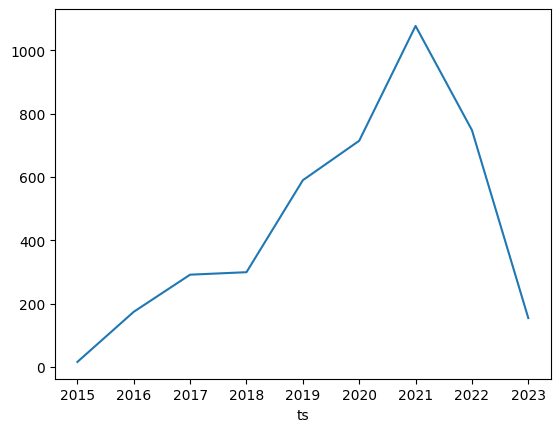

In [97]:
time_sum = df_ms["ms_played"].sum()
dates = df_ms["ts"].dt.strftime("%y - %m").drop_duplicates().tolist()
time_year = df_ms.groupby(df_ms["ts"].dt.year)["ms_played"].sum().apply(lambda x: x/1000/60/60).plot()
print(f"Time played: {np.round(time_sum/1000/60/60, 2)} hours or {np.round(time_sum/1000/60/60/24, 2)} days \n\n Per year: {time_year}")

<Axes: xlabel='ts,ts'>

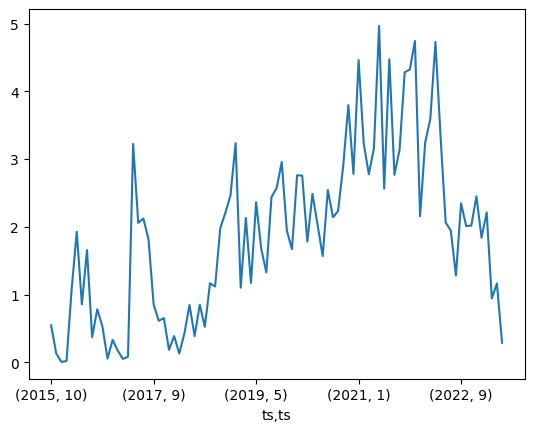

In [106]:
time_yearmonth = df_ms.groupby([df_ms["ts"].dt.year, df_ms["ts"].dt.month])["ms_played"].sum().apply(lambda x: x/1000/60/60/24)
time_yearmonth.plot()

---
## Playtime per song

In [81]:
song_playtime = df_ms.groupby("track_name")["ms_played"].mean()
song_playtime

track_name
"Das ist ein Freimaurer-Raum?" fragte Sato    329600.000000
"Professor Langdon?" fragte Sato              104536.000000
"The Take Over, The Breaks Over"              213586.000000
"Warum antwortet Peter nicht?"                 56167.571429
"Wohin bringen sie mich?" dachte Bellamy      100840.000000
                                                  ...      
早い話                                           230120.000000
真夜中のオーケストラ                                     24793.000000
青と夏                                             8360.000000
이별을 배웠어 Always In My Heart                     26656.000000
회상                                             70658.000000
Name: ms_played, Length: 17617, dtype: float64

---
#Ideas
- 💡 for every year, number of songs played for that amount
- top song percentage
- genre breaks
- play peaks / lows
- top genres
- genre percentage
- interpret percentage
- popularity stats
- top interpretes
- mean playtime @(month/day/hour)
- skipped
    - time
    - percentage
    - heared again?
    - skipped early/late -> heared again?
    - main genre? -> skipped?
- session recognition?
- song cluster